#Step 1: Write your Segmentation Algoirthm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation.  Your algorithm must be based on thresholding and you should consider doing some region processing after segmentation to improve the result.

_Hint: You'll need to be a bit creative when devising your solution -- no single technique from class is likely to give you a particularly good solution, and you may need to think of some tricks that were not explicitly covered in class.  However, you can get a good result with a fairly simple algorithm.  You'll also need to decide how to handle the fact that the input images are colour, although this shouldn't pose too much of a problem, in fact, it is an advantage!_


In [1]:
import skimage.util as util
import skimage.filters as filt
import skimage.morphology as morph
import skimage.measure as meas
import skimage.io as io
import skimage.segmentation as seg
from scipy.ndimage.morphology import binary_fill_holes
import os as os
import numpy as np


def segleaf(I):
    '''
    Segment a leaf image.
    :param I: Color leaf image to segment.
    :return: Logical image where True pixels represent foreground (i.e. leaf pixels).
    '''
    I = util.img_as_float(I)

    # Compute proportion of energy in each pixel that is green.
    green_proportion = I[:,:,1] / (np.sum(I, axis=2) + .0000001)

    # Threshold the green proportion with Otsu threshold
    T = green_proportion > filt.threshold_otsu(green_proportion)

    # Label the regions
    L = morph.label(T, connectivity=1)

    # Get the label of the resulting region with the largest area
    props = meas.regionprops(L)
    max_area_label = props[np.argmax( np.array([x['area'] for x in props]) )]['label']

    # Remove holes and return the region
    filled = binary_fill_holes(L == max_area_label)

    return filled

# Step 2: Implement Measures

Write functions to compute the Mean Squared Distance (MSD), Hausdorff Distance (HD) and Dice Similarity Coefficient (DSC) measures of segmentation quality.  

For MSD and HD, I suggest you reprsent boundaries by N-row, 2-column arrays where each row is the coordinate of one pixel on the region's boundary of the form [r,c], row first, then column.

In [29]:
def shortest_squared_distance(p, B):
    '''
    Shortest squared distance between point p and boundary B
    :param p: a 1x2 array descrbing a 2D point.
    :param B: a Nx2 array of N 2D points.
    :return: shortest squared Euclidean distance between p and B
    '''
    P = np.tile(p, ( B.shape[0], 1) )
    return np.min(np.sum(np.power((P - B),2.0), axis=1))

def msd(A, G):
    '''
    Mean squared distance between two boundaries A and G.
    
    :param A: Nx2 array of boundary points 
    :param G: Mx2 array of boundary points
    :return: the MSD between A and G
    '''

    MSD = 0
    for p in A:
        MSD = MSD + shortest_squared_distance(p,  G)

    return MSD / A.shape[0]


def hd(A, G):
    '''
    Hausdorff distance between two boundaries.
    :param A: Nx2 array of boundary points
    :param G: Mx2 array of boundary points
    :return: Hausdorff distance between the two boundaries.
    '''
    # Find maximum min distance from A to G
    D1 = 0
    for p in A:
        D1 = max(D1, np.sqrt(shortest_squared_distance(p, G)))

    # Find maximum min distance from G to B
    D2 = 0
    for p in G:
        D2 = max(D2, np.sqrt(shortest_squared_distance(p, A)))

    return max(D1, D2)

def dice_coefficient(bwA, bwG):
    '''
    Dice coefficient between two binary images
    :param bwA: a binary (logical) image
    :param bwG: a binary (logical) image
    :return: the Dice coefficient between them
    '''
    intersection = np.logical_and(bwA, bwG)

    return 2.0*np.sum(intersection) / (np.sum(bwA) + np.sum(bwG))

# Step 3: Write a Validation driver program.

Write code that segments each image, and computes the MSD, HD, and DSC for each segmentation.  Print the MSD, HD, and DSC of each segmentation as you perform it.  At the end, print the average and standard deviation of the DSC, the MSD and the HD over all of the images.  Also print the percentage of regions that were "recognized" (see below).  Sample output is in the assignment description document.

The general approach should be, for each input image (in the `images` folder):

* load the image and it's ground truth
* segment the input image - this should be a binary image with a single region (connected component).
* extract the region boundary points from the segmented image and ground truth image; store them in Nx2 arrays as described above (see lecture nodes for an example on how to do this!).
* Compute the MSD and the HD from the two sets of boundary points (using the functions in Step 2).
* Compute the DSC from the segmented image and the ground truth image (using the function from Step 2).
* Determine whether the leaf was "recognized" (a leaf is recognized if it's DSC is greater than 0.6).
* Print the MSD, HD, and DSC to the console (see sample output).

When finished, don't forget to print the average and standard deviation of the DSC for all images, and the percentage of images where the leaf was "recognized".

_Feel free to define additional helper functions for your program if you think it will help._

In [9]:
#### Validate ####

# Paths for files
images_path = os.path.join('.', 'images')
gt_path = os.path.join('.', 'groundtruth')


MSD = []
HD = []
DSC = []
recognized = []

def single_region_boundary_points(B):
    '''
    Get boundary points of a single region.
    
    :param B: A logical (binary) image containing a single connected component.
    :return: Returns an N row, 2 column array where each row is the coordinates 
    one point on the region's bounary.  First coordinate in each row 
    is the pixel row, second coordinate is the pixel column.
    '''
    bp = np.where(seg.find_boundaries(B > 0, connectivity=2, mode='inner') > 0)
    return np.transpose(np.vstack(bp))


for root, dirs, files in os.walk(images_path):
    for filename in files:
        # ignore files that are not PNG files.
        if filename[-4:] != '.png':
            continue

        # Read input images
        I = io.imread(os.path.join(root, filename))

        # Segment it
        S = segleaf(I)

        # Load ground truth image and convert to logical image
        gt = io.imread(os.path.join(gt_path, 'thresh'+filename)).astype(np.bool)

        # Find boundaries of the regions
        Bs = single_region_boundary_points(S)
        Bg = single_region_boundary_points(gt)

        MSD.append(msd(Bs, Bg))
        HD.append(hd(Bs, Bg))
        DSC.append(dice_coefficient(S, gt))

        if DSC[-1] >= .6:
            recognized.append(True)
        else:
            recognized.append(False)

        print('DSC for {}: {}'.format(filename, DSC[-1]))
        print('MSD for {}: {}'.format(filename, MSD[-1]))
        print('HD for {}: {}'.format(filename, HD[-1]))
        print('--------------------------------------------------')

    print('The mean Dice coefficient was: {}'.format(np.mean(np.array(DSC))))
    print('The std. deviation of  Dice coefficient was: {}'.format(np.std(np.array(DSC))))
    print('The mean MSD was: {}'.format(np.mean(np.array(MSD))))
    print('The std. deviation of  MSD was: {}'.format(np.std(np.array(MSD))))
    print('The mean HD was: {}'.format(np.mean(np.array(HD))))
    print('The std. deviation of  HD was: {}'.format(np.std(np.array(HD))))
    print('{}% of leaves were recognized.'.format(np.sum(np.array(recognized))/len(recognized)*100))

DSC for image_0001.png: 0.998710905737
MSD for image_0001.png: 0.135073779796
HD for image_0001.png: 6.32455532034
--------------------------------------------------


DSC for image_0002.png: 0.998759405593
MSD for image_0002.png: 0.0851565129586
HD for image_0002.png: 4.0
--------------------------------------------------


DSC for image_0005.png: 0.99875911561
MSD for image_0005.png: 0.10686482661
HD for image_0005.png: 2.82842712475
--------------------------------------------------


DSC for image_0007.png: 0.998298494372
MSD for image_0007.png: 17.6741134752
HD for image_0007.png: 41.0121933088
--------------------------------------------------


DSC for image_0009.png: 0.998697842229
MSD for image_0009.png: 0.407928862542
HD for image_0009.png: 12.0415945788
--------------------------------------------------


DSC for image_0010.png: 0.998975684706
MSD for image_0010.png: 0.0625925925926
HD for image_0010.png: 1.41421356237
--------------------------------------------------


DSC for image_0011.png: 0.99928954337
MSD for image_0011.png: 0.0436766623207
HD for image_0011.png: 2.0
--------------------------------------------------


DSC for image_0015.png: 0.998100089207
MSD for image_0015.png: 25.2115167482
HD for image_0015.png: 57.0
--------------------------------------------------


DSC for image_0018.png: 0.998344127406
MSD for image_0018.png: 0.110636784063
HD for image_0018.png: 3.16227766017
--------------------------------------------------


DSC for image_0019.png: 0.998629161154
MSD for image_0019.png: 0.0858676207513
HD for image_0019.png: 3.0
--------------------------------------------------


DSC for image_0078.png: 0.99925925457
MSD for image_0078.png: 0.0776203966006
HD for image_0078.png: 2.0
--------------------------------------------------


DSC for image_0080.png: 0.998934666162
MSD for image_0080.png: 0.22232601588
HD for image_0080.png: 6.0
--------------------------------------------------


DSC for image_0089.png: 0.995156760863
MSD for image_0089.png: 1.05882352941
HD for image_0089.png: 9.05538513814
--------------------------------------------------


DSC for image_0090.png: 0.99454017084
MSD for image_0090.png: 4.32594936709
HD for image_0090.png: 19.2353840617
--------------------------------------------------


DSC for image_0099.png: 0.998766937197
MSD for image_0099.png: 0.0922473012758
HD for image_0099.png: 3.0
--------------------------------------------------


DSC for image_0100.png: 0.998576509067
MSD for image_0100.png: 0.186046511628
HD for image_0100.png: 3.60555127546
--------------------------------------------------


DSC for image_0104.png: 0.998037495382
MSD for image_0104.png: 3.26882745472
HD for image_0104.png: 14.1421356237
--------------------------------------------------


DSC for image_0105.png: 0.99829990181
MSD for image_0105.png: 3.3579730358
HD for image_0105.png: 18.0277563773
--------------------------------------------------


DSC for image_0110.png: 0.997898365188
MSD for image_0110.png: 0.207920792079
HD for image_0110.png: 3.60555127546
--------------------------------------------------


DSC for image_0113.png: 0.997091237945
MSD for image_0113.png: 0.241970963484
HD for image_0113.png: 4.0
--------------------------------------------------


DSC for image_0132.png: 0.998610508802
MSD for image_0132.png: 0.15680684248
HD for image_0132.png: 4.472135955
--------------------------------------------------


DSC for image_0160.png: 0.998741249875
MSD for image_0160.png: 0.185489902767
HD for image_0160.png: 4.0
--------------------------------------------------


DSC for image_0161.png: 0.998819324002
MSD for image_0161.png: 0.108187134503
HD for image_0161.png: 1.41421356237
--------------------------------------------------


DSC for image_0162.png: 0.998533120169
MSD for image_0162.png: 0.138584974471
HD for image_0162.png: 2.0
--------------------------------------------------


DSC for image_0163.png: 0.998976698931
MSD for image_0163.png: 0.089364844904
HD for image_0163.png: 2.0
--------------------------------------------------


DSC for image_0165.png: 0.998562902599
MSD for image_0165.png: 0.132188200149
HD for image_0165.png: 2.0
--------------------------------------------------


DSC for image_0166.png: 0.99899770586
MSD for image_0166.png: 0.108825481088
HD for image_0166.png: 3.60555127546
--------------------------------------------------


DSC for image_0171.png: 0.997679226972
MSD for image_0171.png: 0.227767114523
HD for image_0171.png: 5.0
--------------------------------------------------


DSC for image_0174.png: 0.998673663572
MSD for image_0174.png: 0.196483180428
HD for image_0174.png: 4.472135955
--------------------------------------------------


DSC for image_0175.png: 0.998448382262
MSD for image_0175.png: 0.17337883959
HD for image_0175.png: 4.24264068712
--------------------------------------------------
The mean Dice coefficient was: 0.998305615048
The std. deviation of  Dice coefficient was: 0.00103013053067
The mean MSD was: 1.94934032493
The std. deviation of  MSD was: 5.40515206376
The mean HD was: 8.28872342473
The std. deviation of  HD was: 11.9692827962
100% of leaves were recognized.


# Step 4:  Display Examples

Choose one input image where your algoirthm performed very well.  Choose another image where the algorithm did not perform well.  Display the two original images with the segmentation superimposed on top (There is an example in the lecture notes -- last slide, Topic 6 -- showing how to do this).  Also display the same two image's ground truth with the segmentation superimposed on top.    Title the images to indicate which is the "good" example, and which is the "bad" example.


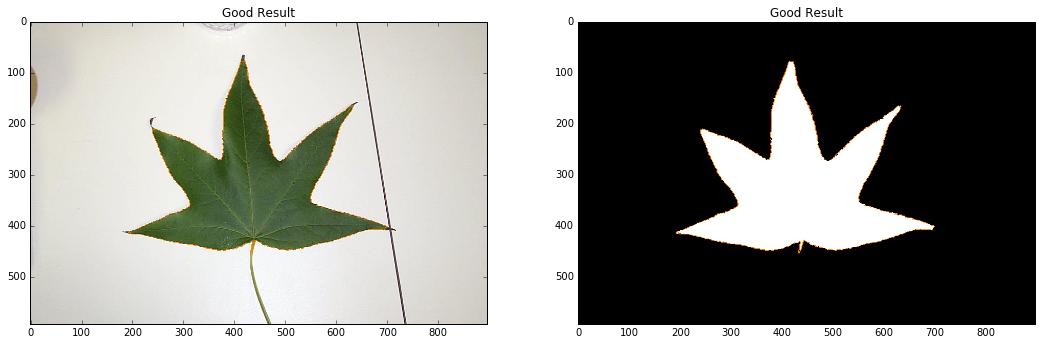

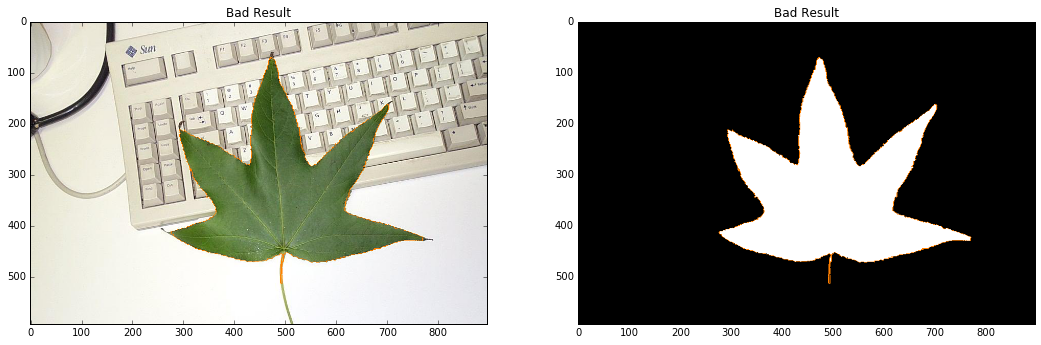

In [36]:
import matplotlib.pyplot as plt

% matplotlib inline

good = io.imread('images/image_0001.png')
bad = io.imread('images/image_0007.png')
good_gt = io.imread('groundtruth/threshimage_0001.png')
bad_gt = io.imread('groundtruth/threshimage_0007.png')

good_seg = segleaf(good)
bad_seg = segleaf(bad)

good_label = morph.label(good_seg)
bad_label = morph.label(bad_seg)

plt.subplots(1, 2, figsize=(18,6))
plt.subplot(121)
plt.imshow(seg.mark_boundaries(good, good_label, color=(1,.5,0)))
plt.title('Good Result')
plt.subplot(122)
plt.imshow(seg.mark_boundaries(good_gt, good_label, color=(1,.5,0)))
plt.title('Good Result')

plt.figure()
plt.subplots(1, 2, figsize=(18,6))
plt.subplot(121)
plt.imshow(seg.mark_boundaries(bad, bad_label, color=(1,.5,0)))
plt.title('Bad Result')
plt.subplot(122)
plt.imshow(seg.mark_boundaries(bad_gt, bad_label, color=(1,.5,0)))
plt.title('Bad Result')

# Step 5: A time for reflection.

### Answer the following questions right here in this block.

1. In a few sentences, briefly explain what your segmentation algorithm from Step 1 does and how it works.  

	_Your answer:_  My algorithm computes for each pixel the proprotion of the pixel's "greenness", i.e. G/(R+G+B).  Then this is thresholded with a threshold determined by the Otsu method.  The largest connected component of the resulting binary image is retained, while other components are discarded.  Holes are filled in the remaining component, and this is returned as the segmentation.

2. Consider your good result.  What, if anything, about your algoirthm is preventing you from getting a better result with this image?  If you weren't able to get any results, leave this blank, or explain what was preventing you from getting a result.

	_Your answer:_  My results are almost perfect because the ground truth was generated using essentially the same algorithm as my segmentation algorithm.  Slight differences are probably a result of converting to JPEG and back to PNG, otherwise my results would be perfect matches. 

3. Consider your bad result.  What is it about your algoirthm caused the poor performance on this image?   If you weren't able to get any results, leave this blank.

	_Your answer:_  This is one of my worst results in terms of Hausdorff distance.  The algorithm gets a much larger portion of the stem than is in the ground truth causing an HD of about 40, but still much of the stem is missed because the stem did not have enough "greenness" to exceed the selected threshold.  Otsu can be an unreliable way of selecting a threshold because the strict assumptions of the method are often not true.
